# Hidden Markov Models (HMMs)

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt

# matplotlib configuration
import matplotlib as mpl
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["figure.figsize"] = (15, 5)
# retina display only (e.g. MacOS)
%config InlineBackend.figure_format = 'retina'

### 2-State (Closed $\rightleftarrows$ Open) HMM for an ion channel

Starting probability in each state:

In [19]:
p0 = np.array([0.5, 0.5])  # P(C), P(O)

Transition probabilities per time step:

In [20]:
trans = np.array([[0.95, 0.05],   # P(C->C), P(C->O)
                  [0.15, 0.85]])  # P(O->C), P(O->O)

Emission (i.e. ionic current) distributions for each state:

In [21]:
emis = [st.norm(0, 1), st.norm(5, 1)]  # closed, open current distributions

### HMM Simulation

In [22]:
def simulateHMM(p0, trans, emis, numSamples):
    numStates = len(p0)
    stateIds = np.arange(numStates, dtype=int)  # 0, 1, ..., numStates-1
    
    # preallocate simulation arrays
    stateSequence = np.zeros(numSamples, dtype=int)
    observationSequence = np.zeros(numSamples)
    
    # reset pseudo random number generator
    np.random.seed(0)
    
    # randomly assign starting state
    stateSequence[0] = np.random.choice(stateIds, p=p0)
    
    # randomly assign subsequent states based on the transition probabilities
    for t in range(1, numSamples):
        prevState = stateSequence[t-1]
        stateSequence[t] = np.random.choice(stateIds, p=trans[prevState,:])
    
    # randomly draw state observations from emission distributions
    for state in stateIds:
        stateMask = (stateSequence == state)
        observationSequence[stateMask] = emis[state].rvs(stateMask.sum())
    
    return stateSequence, observationSequence

In [23]:
stateSeq, observationSeq = simulateHMM(p0, trans, emis, 1000)

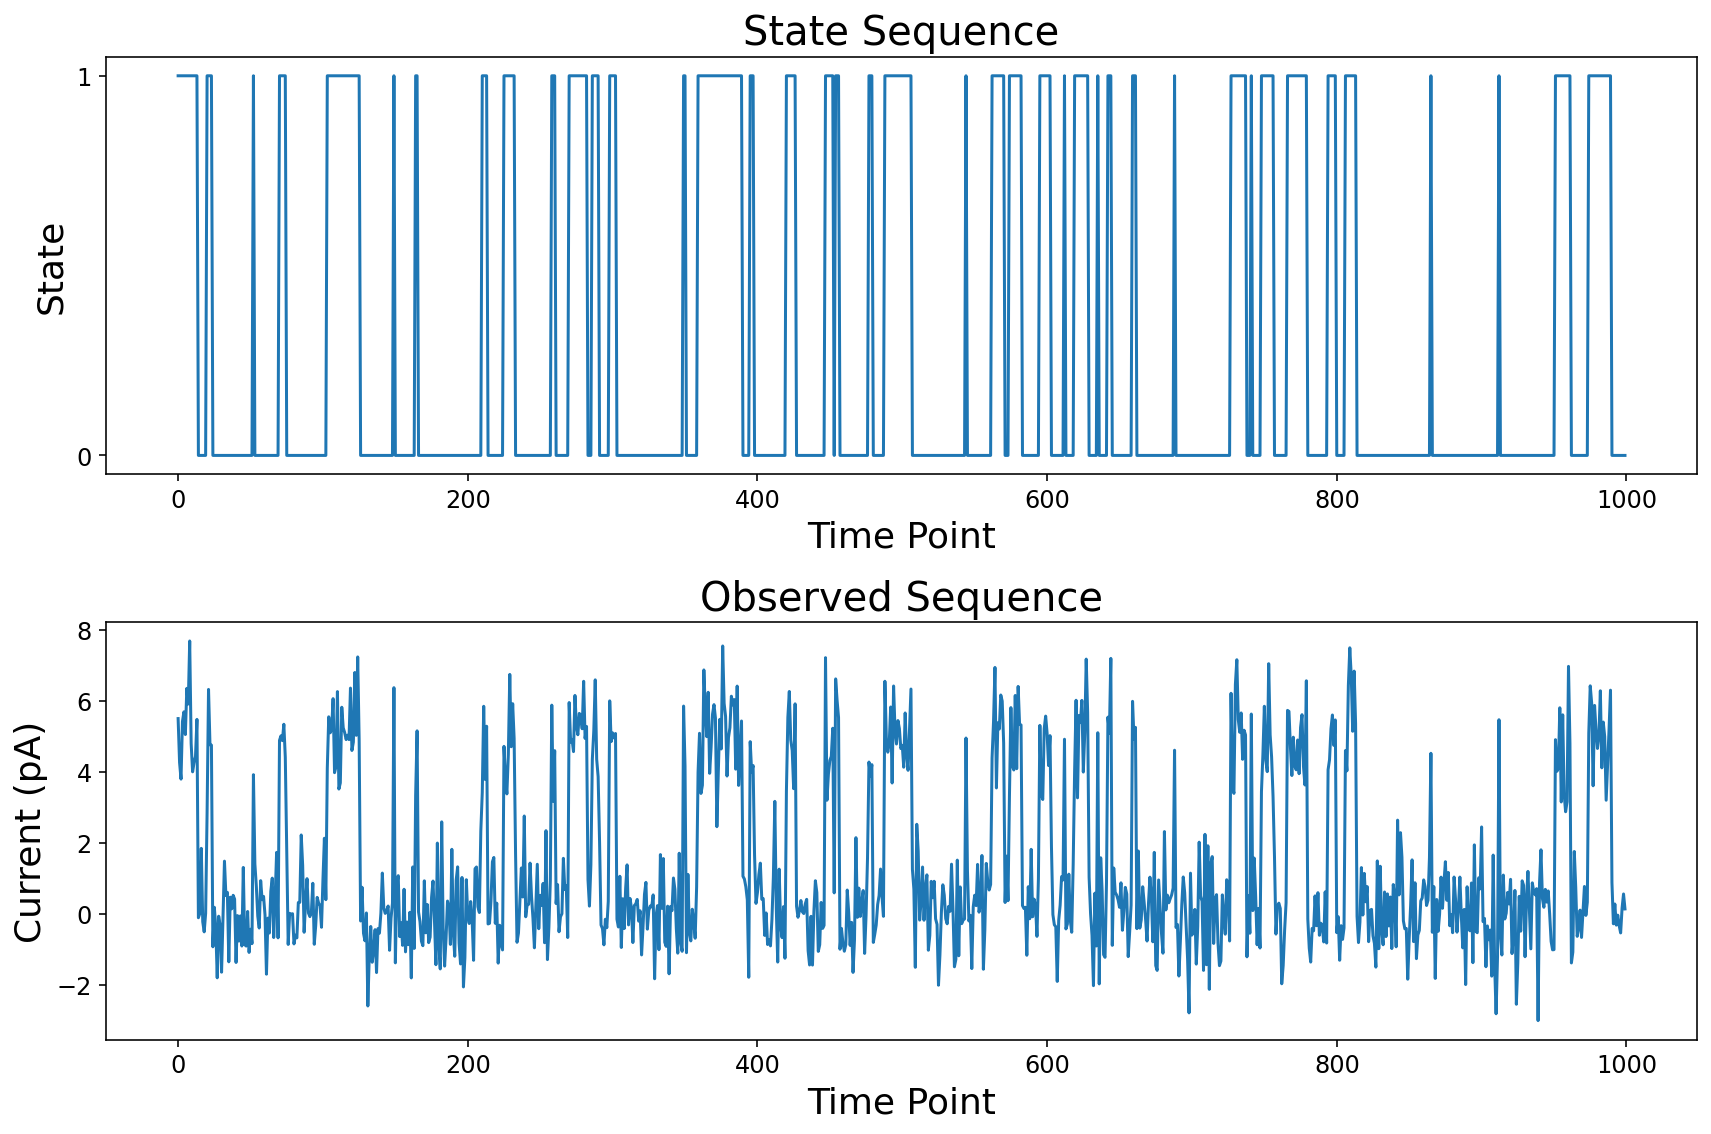

In [24]:
# state and observation sequences
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(stateSeq)
plt.yticks(np.unique(stateSeq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence')
plt.subplot(2,1,2)
plt.plot(observationSeq)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Observed Sequence')
plt.tight_layout();

### Threshold Idealization of Observations

In [25]:
threshold = 2.5
predictedStateSeq = np.zeros(observationSeq.shape, dtype=int)
predictedStateSeq[observationSeq < threshold] = 0
predictedStateSeq[observationSeq >= threshold] = 1

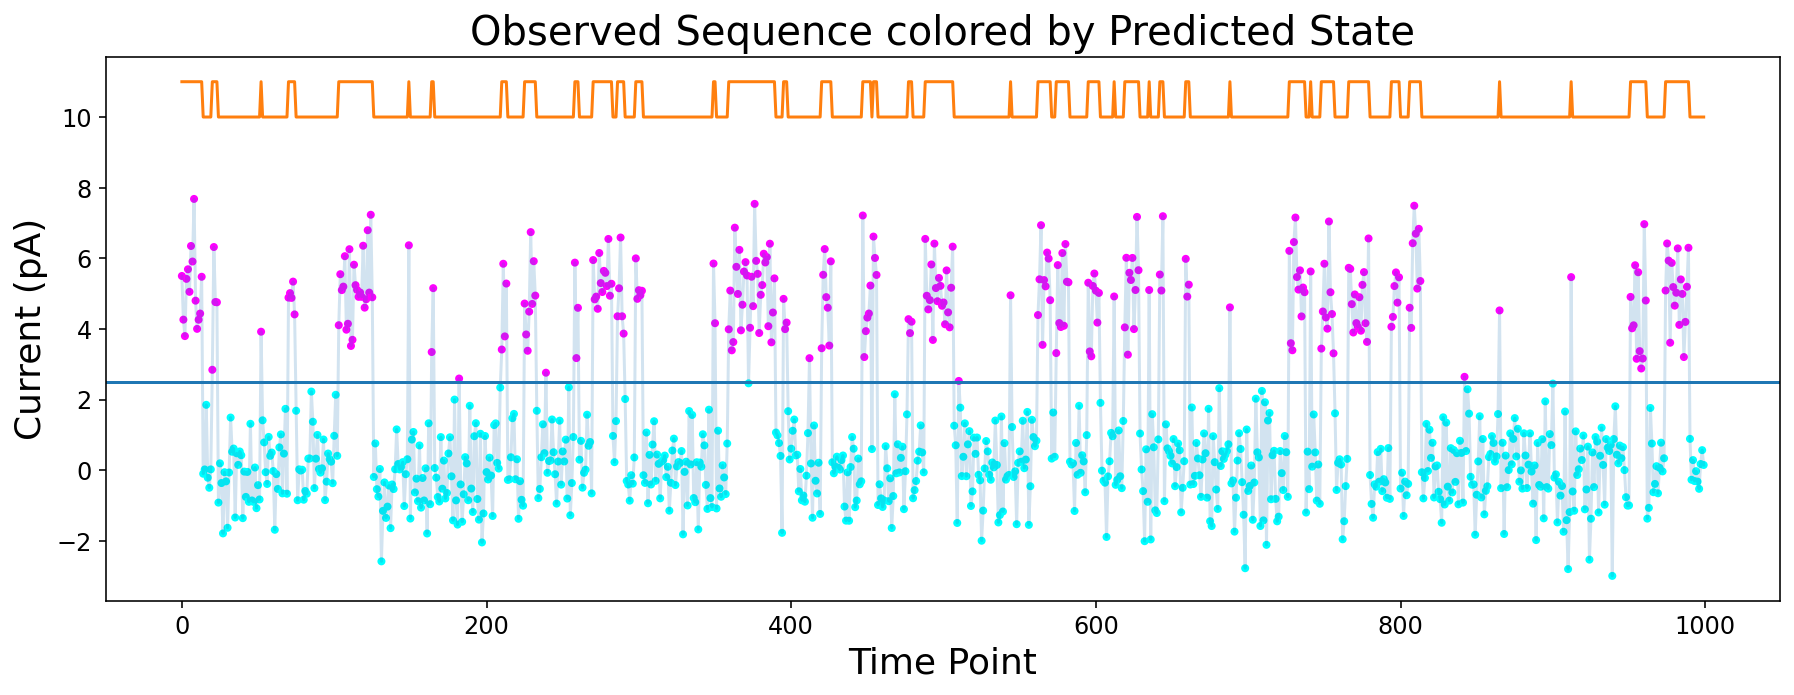

In [26]:
# thresholded state assignment
plt.plot(observationSeq, alpha=0.2)
plt.scatter(range(len(observationSeq)), observationSeq, marker='.', c=predictedStateSeq, cmap='cool')
plt.axhline(threshold)
plt.plot(stateSeq + 10)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Observed Sequence colored by Predicted State');

How well did thresholding do?

Can you think of a case where thresholding won't work well?

Other clustering methods such as GMMs, kmeans, etc. can also classify states by amplitude.

We'll explore some of these later in the semester.

## <font color=red> However, amplitude clustering can NOT:</font>

* distinguish states with identical or very similar emissions
* distinguish between a random large noise fluctuation and a transition

## <font color=blue>HMMs can do this.</font>

# Filtering and Missed Events

In [27]:
dt_ms = 0.1
fs_kHz = 1 / dt_ms
time_ms = np.arange(len(observationSeq)) * dt_ms
current_pA = observationSeq

In [28]:
from scipy import signal

lowpass2kHz = signal.firwin(301, 2, nyq=fs_kHz/2)
lowpass1kHz = signal.firwin(301, 1, nyq=fs_kHz/2)

filtered2kHz = np.convolve(current_pA, lowpass2kHz, 'same')
filtered1kHz = np.convolve(current_pA, lowpass1kHz, 'same')

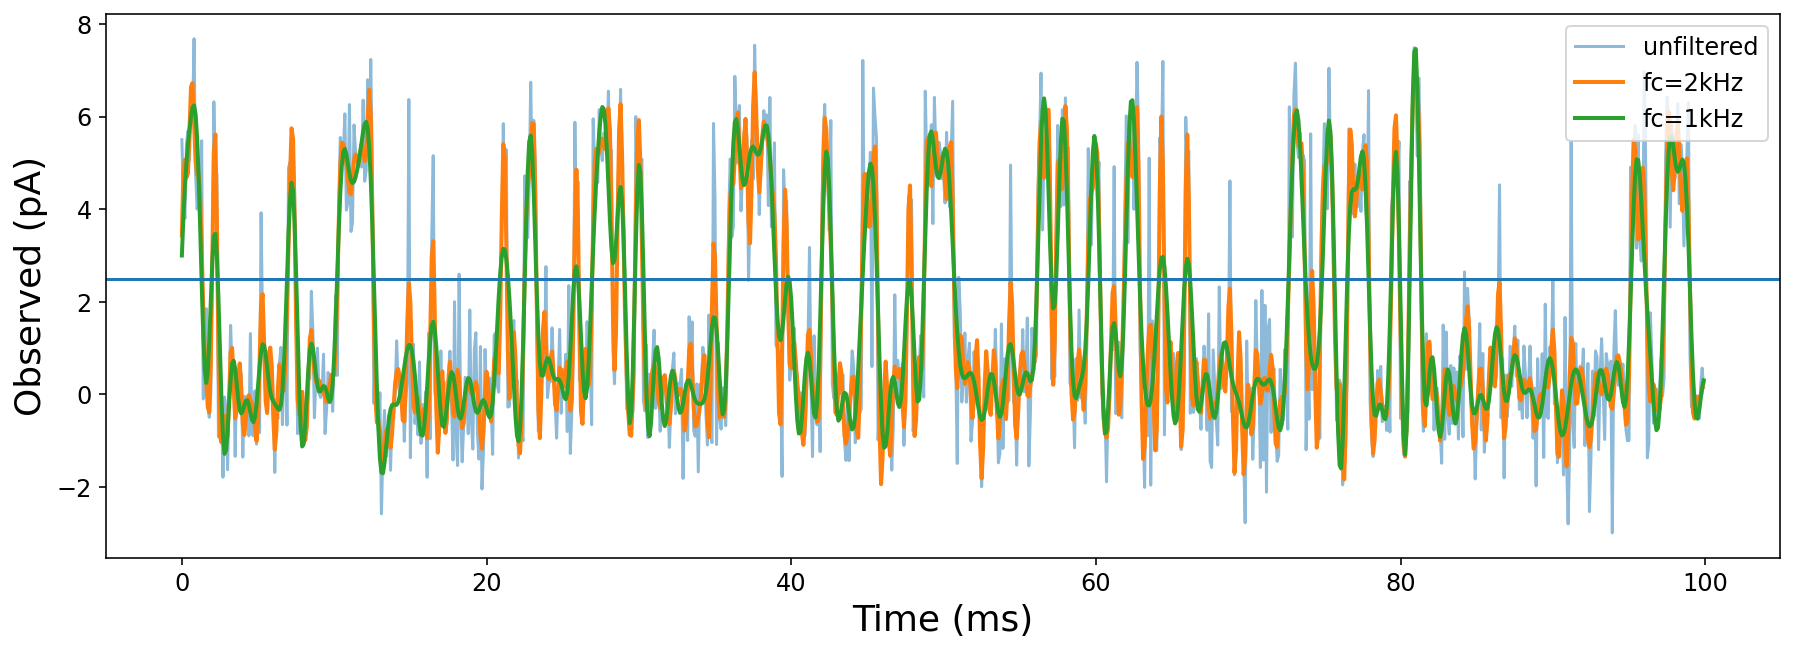

In [29]:
plt.plot(time_ms, current_pA, alpha=0.5, label='unfiltered')
plt.plot(time_ms, filtered2kHz, lw=2, label='fc=2kHz')
plt.plot(time_ms, filtered1kHz, lw=2, label='fc=1kHz')
plt.axhline(threshold)
plt.xlabel('Time (ms)')
plt.ylabel('Observed (pA)');
plt.legend();

Examine the plot and see if you can think of a **pro** and a **con** of filtering.

### 3-State (Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized) HMM for an ion channel

Starting probability in each state:

In [30]:
p0 = np.array([1, 0, 0])  # P(C), P(O), P(D)

Transition probabilities per time step:

In [31]:
trans = np.array([[0.950, 0.050, 0.000],   # P(C->C), P(C->O), P(C->D)
                  [0.030, 0.950, 0.020],   # P(O->C), P(O->O), P(O->D)
                  [0.000, 0.004, 0.996]])  # P(D->C), P(D->O), P(D->D)

Emission (i.e. ionic current) distributions for each state:

In [32]:
emis = [st.norm(0, 1), st.norm(5, 1), st.norm(0, 1)]

Simulate some data for the HMM:

In [33]:
stateSeq, current_pA = simulateHMM(p0, trans, emis, 1000000)

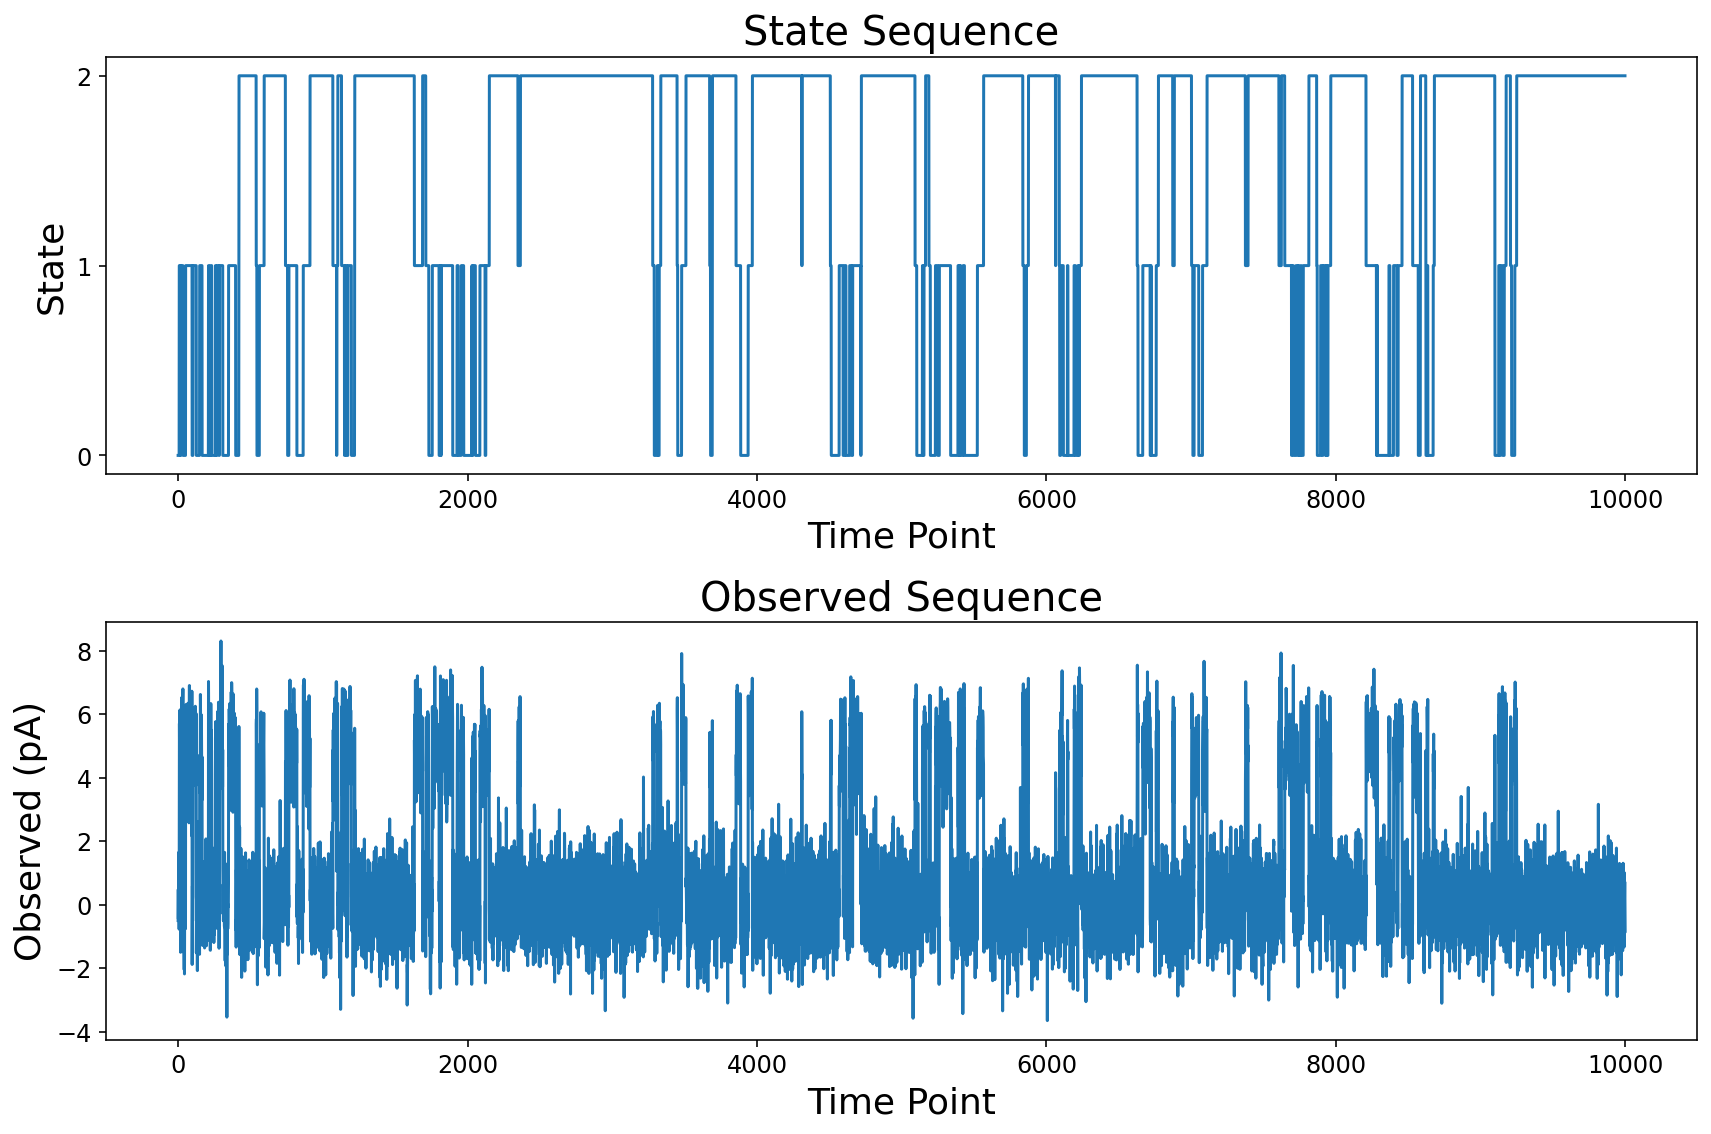

In [34]:
# state and observation sequences
n = 10000
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(stateSeq[:n])
plt.yticks(np.unique(stateSeq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence')
plt.subplot(2,1,2)
plt.plot(current_pA[:n])
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence')
plt.tight_layout();

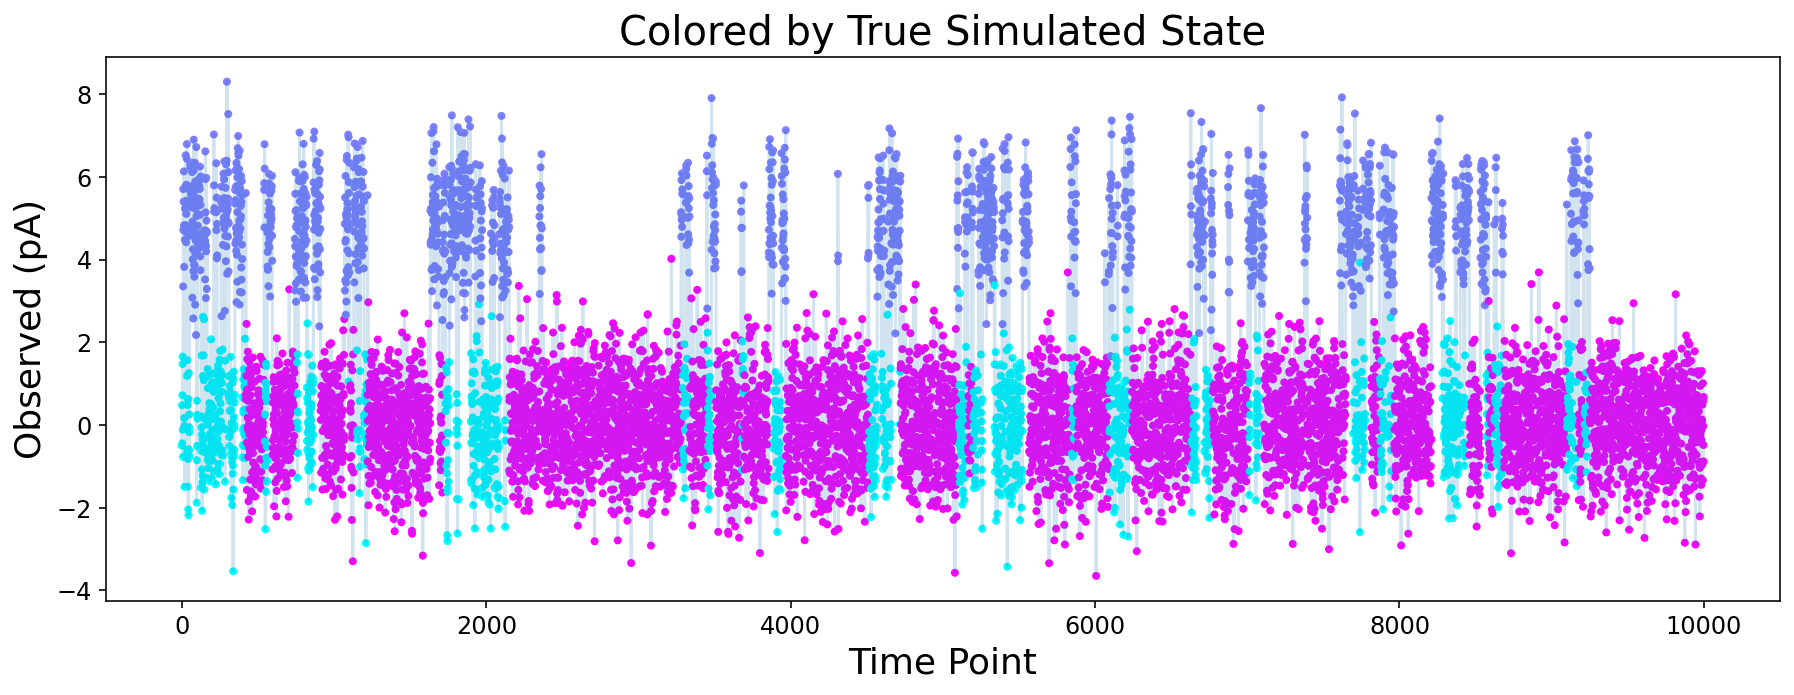

In [35]:
n = 10000
plt.plot(current_pA[:n], alpha=0.2)
plt.scatter(range(n), current_pA[:n], marker='.', c=stateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by True Simulated State');

How might you distinguish between the closed and desensitized states?

### Dwell Time Distributions

Examination of these distributions can suggest how many states at each emission level you should include in your model.

In [36]:
dwelltimes = {}
for i in np.unique(stateSeq):
    dwelltimes[i] = []
for i, state in enumerate(stateSeq):
    if i > 0 and stateSeq[i-1] == state:
        dwelltimes[state][-1] += 1
    else:
        dwelltimes[state].append(1)

shutTimes = dwelltimes[0] + dwelltimes[2]
openTimes = dwelltimes[1]

dt_ms = 0.1
shutTimes_ms = np.array(shutTimes) * dt_ms
openTimes_ms = np.array(openTimes) * dt_ms

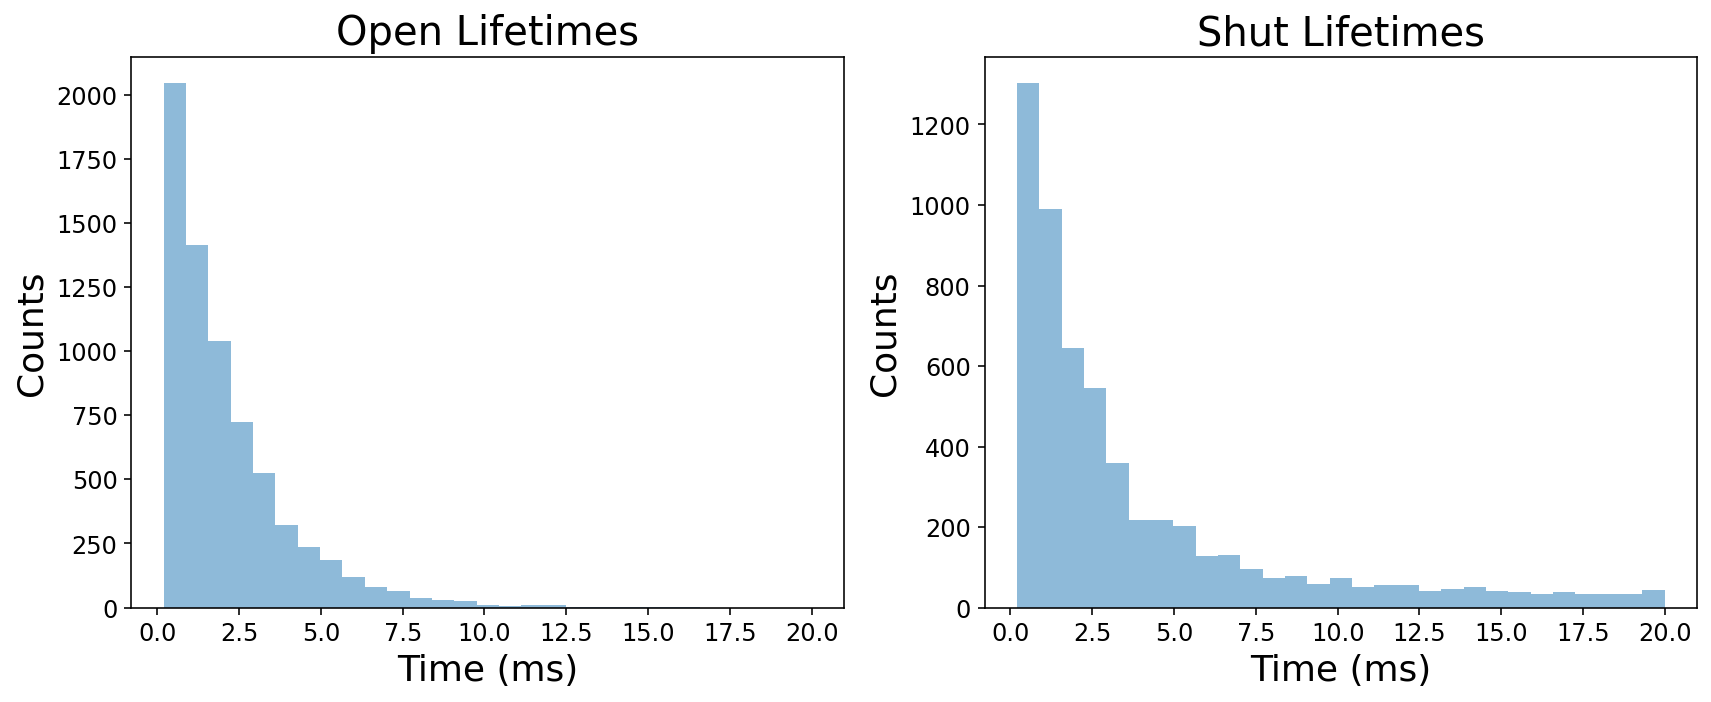

In [37]:
# dwell time histograms
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
binedges = np.linspace(0.2, 20, 30)
plt.hist(openTimes_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Open Lifetimes')
plt.subplot(1, 2, 2)
binedges = np.linspace(0.2, 20, 30)
plt.hist(shutTimes_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Shut Lifetimes')
plt.tight_layout();

Dwelltimes are often binned and plotted on a logscale.

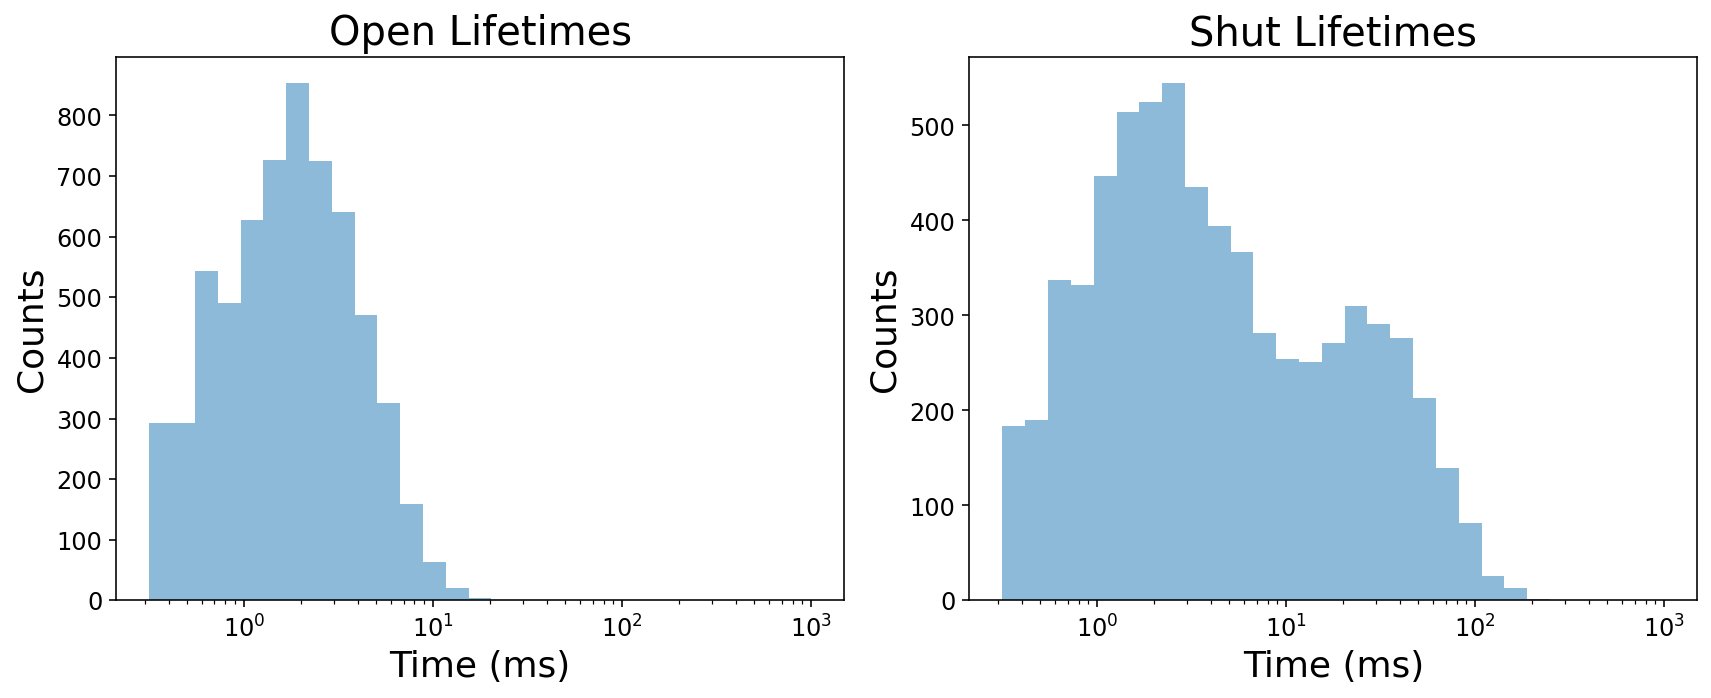

In [38]:
# dwell time histograms on logscale
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
binedges = np.logspace(-0.5, 3, 30)
plt.hist(openTimes_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Open Lifetimes')
plt.xscale('log')
plt.subplot(1, 2, 2)
binedges = np.logspace(-0.5, 3, 30)
plt.hist(shutTimes_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Shut Lifetimes')
plt.xscale('log')
plt.tight_layout();

### Observations $\rightarrow$ HMM

`pip install pomegranate==0.14.3` <-- Version is important as latest version has some bugs!

In [39]:
import pomegranate as pom

### Postulate a HMM to explain the observed current sequence.

In [40]:
hmm = pom.HiddenMarkovModel()

In [41]:
# states
C = pom.State(pom.NormalDistribution(1, 0.8), name='Closed')
O = pom.State(pom.NormalDistribution(7, 1), name='Open')
D = pom.State(pom.NormalDistribution(0, 0.8), name='Desensitized')
hmm.add_states([C, O, D])

In [42]:
# starting probability in each state (MUST add to one)
hmm.add_transition(hmm.start, C, 0.9)
hmm.add_transition(hmm.start, O, 0.1)

In [43]:
# transition probabilites per time step between states
hmm.add_transition(C, C, 0.90)
hmm.add_transition(C, O, 0.10) # sum from C MUST add to one

hmm.add_transition(O, C, 0.05)
hmm.add_transition(O, O, 0.90)
hmm.add_transition(O, D, 0.05) # sum from O MUST add to one

hmm.add_transition(D, O, 0.05)
hmm.add_transition(D, D, 0.95) # sum from D MUST add to one

In [44]:
# we have to bake it before we can use it!
hmm.bake()

`hmm.states`

A list of dictionaries (one per state) with info about the HMM.

In [45]:
hmm.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             1.0,
             0.8
         ],
         "frozen" : false
     },
     "name" : "Closed",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             0.0,
             0.8
         ],
         "frozen" : false
     },
     "name" : "Desensitized",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             7.0,
             1.0
         ],
         "frozen" : false
     },
     "name" : "Open",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution"

In [46]:
hmm.states[0]

{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "name" : "NormalDistribution",
        "parameters" : [
            1.0,
            0.8
        ],
        "frozen" : false
    },
    "name" : "Closed",
    "weight" : 1.0
}

In [47]:
hmm.states[0].name

'Closed'

In [48]:
# mean, standard deviation
hmm.states[0].distribution.parameters

[1.0, 0.8]

In [49]:
stateNames = [state.name for state in hmm.states]
stateNames

['Closed', 'Desensitized', 'Open', 'None-start', 'None-end']

!!! Beware, the order of the states may be changed when you bake the HMM.

Initial parameters. These are just the parameters we specified above.

The row/column order of the transition matrix corresponds to the state order.

In [50]:
hmm.dense_transition_matrix()

array([[0.9 , 0.  , 0.1 , 0.  , 0.  ],
       [0.  , 0.95, 0.05, 0.  , 0.  ],
       [0.05, 0.05, 0.9 , 0.  , 0.  ],
       [0.9 , 0.  , 0.1 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

In [54]:
import pandas as pd

def printModelParams(hmm):
    A = hmm.dense_transition_matrix()
    Af = pd.DataFrame(A, index=stateNames, columns=stateNames)
    Bf = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], 
             index=stateNames[:3], columns=['mean', 'std'])
    states = ["Closed", "Open", "Desensitized"]
    print('Starting state probabilities:')
    print('-----------------------------')
    print(Af.loc[["None-start"], states])
    print()
    print('Transition probabilities:')
    print('-------------------------')
    print(Af.loc[states, states])
    print()
    print('Emission distribution parameters:')
    print('---------------------------------')
    print(Bf.loc[states,:])

In [55]:
# initial model (our starting guess for all parameters)
printModelParams(hmm)

Starting state probabilities:
-----------------------------
            Closed  Open  Desensitized
None-start     0.9   0.1           0.0

Transition probabilities:
-------------------------
              Closed  Open  Desensitized
Closed          0.90  0.10          0.00
Open            0.05  0.90          0.05
Desensitized    0.00  0.05          0.95

Emission distribution parameters:
---------------------------------
              mean  std
Closed         1.0  0.8
Open           7.0  1.0
Desensitized   0.0  0.8


Probability that our initial postulated model explains our observations.

In [56]:
hmm.probability(current_pA)

0.0

In [57]:
hmm.probability(current_pA[:100])  # less points

1.2244402059695228e-124

In [58]:
hmm.log_probability(current_pA)

-1849395.916627575

In [59]:
initialLogProb = hmm.log_probability(current_pA)

### Optimize the HMM parameters to best explain the first 10,000 time points of our observations.

Baum-Welch is a widely used algorithm for optimizing the parameters of an HMM.

In [60]:
hmm.fit([current_pA[:10000]], algorithm='baum-welch');

Optimized HMM parameters in Pandas tables.

In [61]:
# optimized model parameters
printModelParams(hmm)

Starting state probabilities:
-----------------------------
            Closed  Open  Desensitized
None-start     1.0   0.0           0.0

Transition probabilities:
-------------------------
                Closed      Open  Desensitized
Closed        0.950084  0.049916      0.000000
Open          0.040737  0.943310      0.015953
Desensitized  0.000000  0.004561      0.995439

Emission distribution parameters:
---------------------------------
                  mean       std
Closed       -0.002291  0.993557
Open          5.007621  0.975000
Desensitized  0.017671  0.998631


Probability that our optimized model explains our observations.

In [62]:
finalLogProb = hmm.log_probability(current_pA)

initialLogProb, finalLogProb

(-1849395.916627575, -1486336.3265858805)

In [63]:
finalLogProb > initialLogProb

True

### Use the optimized HMM to predict the state sequence underlying the observations.

In [64]:
predictedStateSeq = hmm.predict(current_pA)

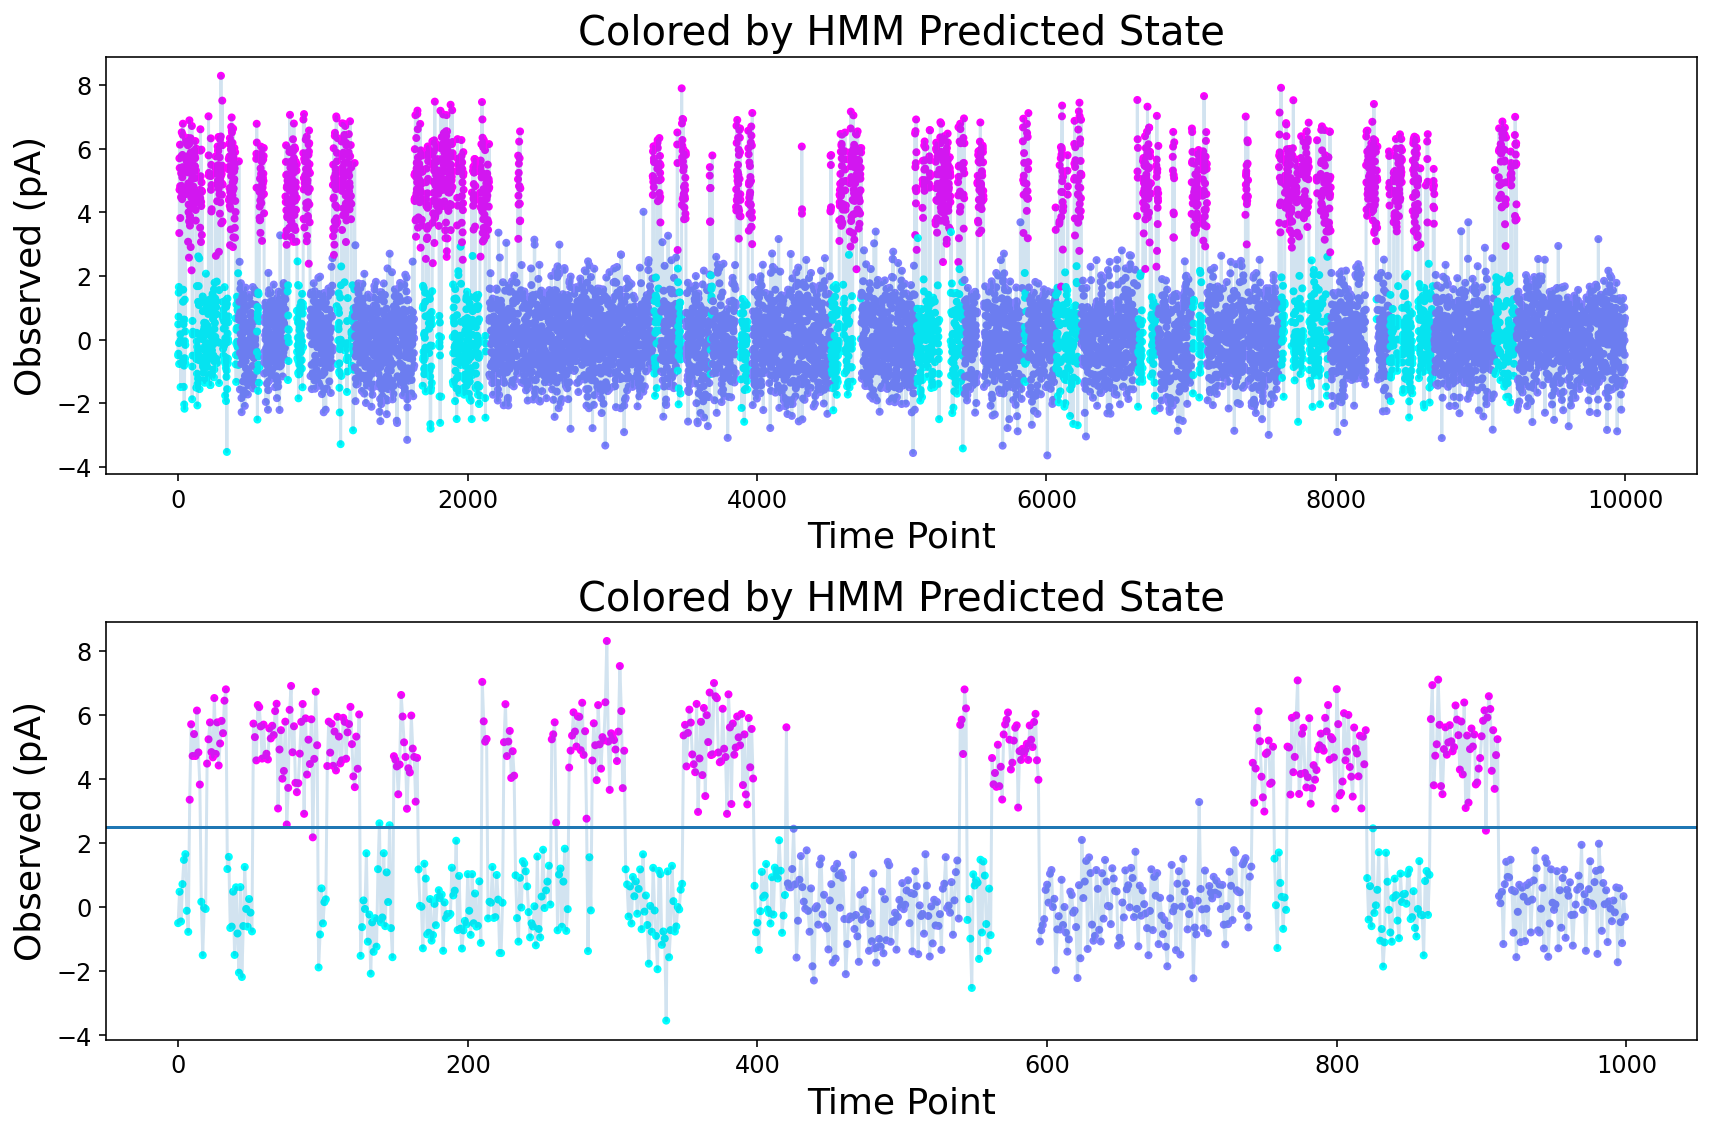

In [68]:
# predicted state sequence
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
n = 10000
plt.plot(current_pA[:n], alpha=0.2)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State')
plt.subplot(2, 1, 2)
n = 1000
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State')
plt.tight_layout();

Predicted state probabilities at each time step.

In [70]:
predictedStateProb = hmm.predict_proba(current_pA)

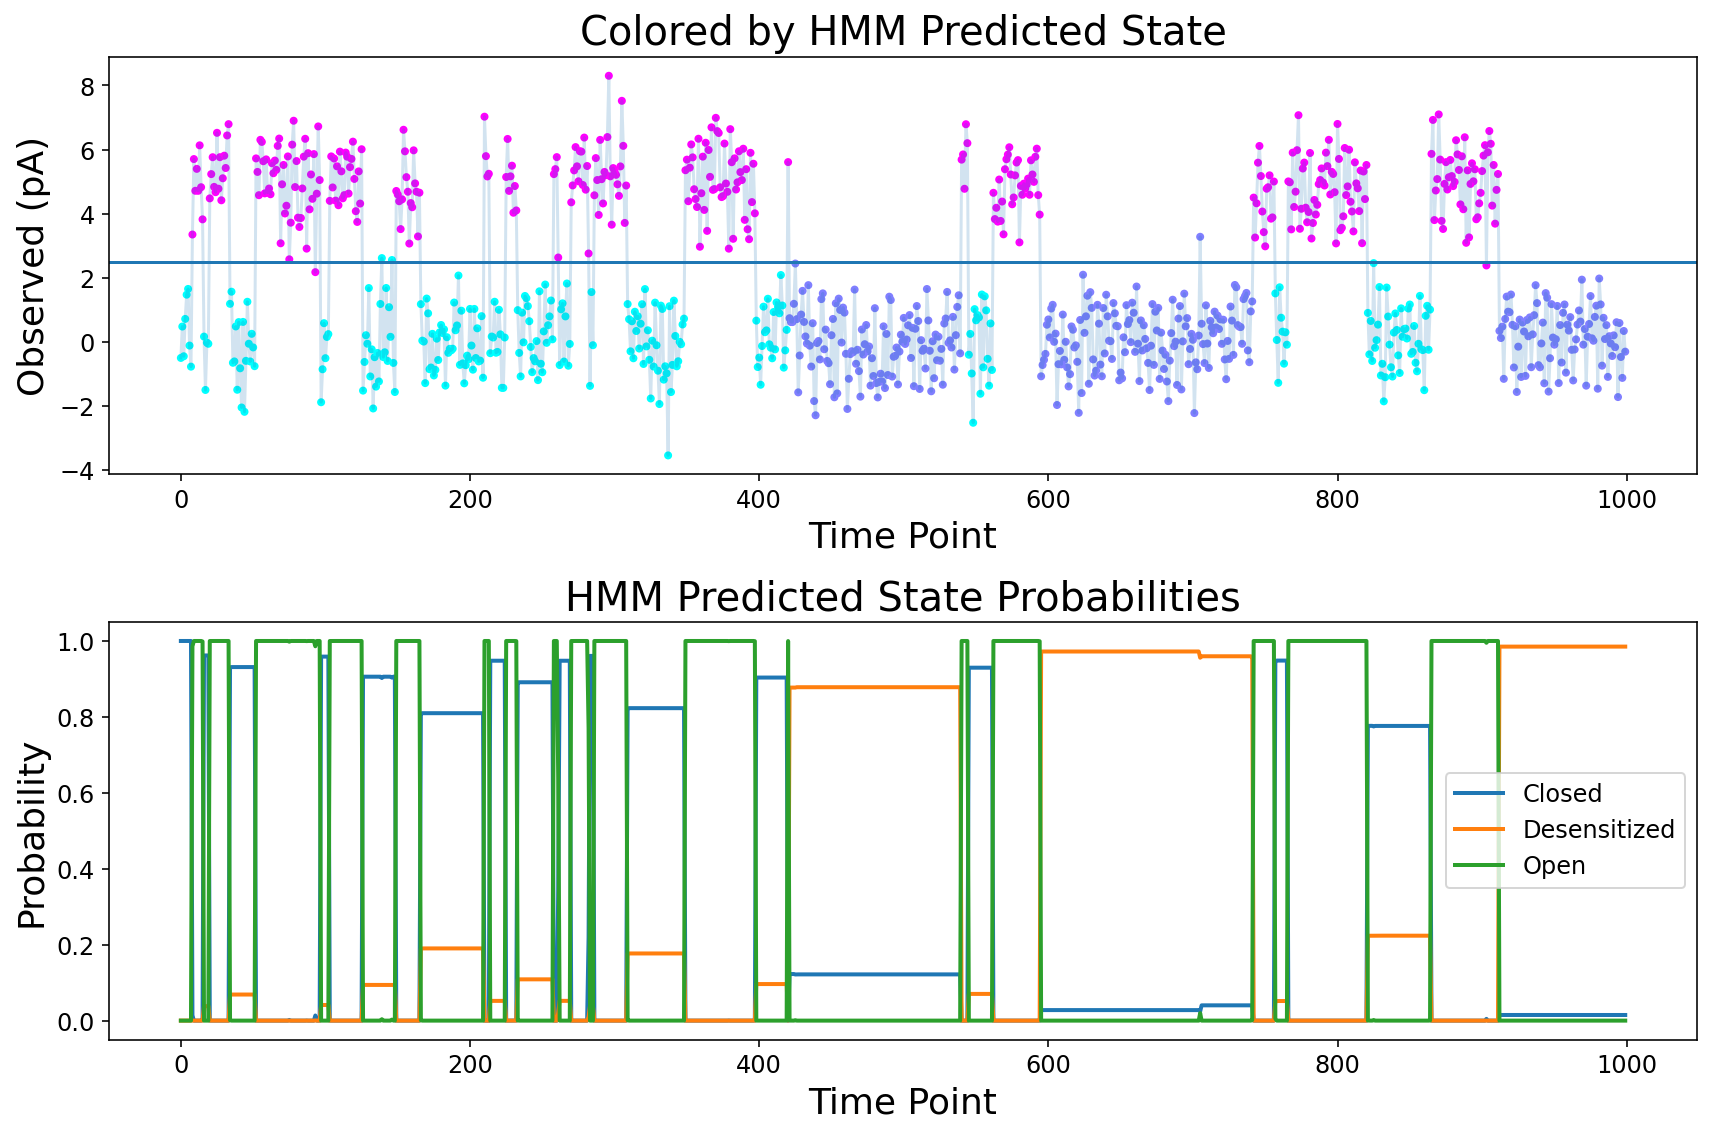

In [72]:
# predicted state sequence
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
n = 1000
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State')
plt.subplot(2, 1, 2)
n = 1000
plt.plot(predictedStateProb[:n], lw=2)
plt.xlabel('Time Point')
plt.ylabel('Probability')
plt.title('HMM Predicted State Probabilities')
plt.legend(stateNames[:3])
plt.tight_layout();

# <font color=darkred> Exercise Part 1</font>

1. Using pomegranate build a model with 2-4 states whose emitted observations come from normal distributions and which are connected by up to 6 possible allowed transitions. You choose exactly how many states between 2 and 4, what the emission distribution parameters are for each state, and what the transition probabilites are between states. Please make the states distinct from each other in some way, either in emission or transition rate, but not necessarily both. Also make the probability of staying in each state per time step at least 0.5, otherwise their lifetime will be too close to the sample frequency.

2. Simulate a sequence of 100,000 observations using your model.
    
3. Make two plots showing your simulated noisy sequence - one plot showing the full sequence, and another plot zoomed in on the x-axis to clearly show a handful of simulated events (up to you, but maybe ~1000 pts).

# <font color=darkred> Exercise Part 2</font>

In a group, choose one person's simulated data. That person will share their screen to show their simulated data. **!!! BUT MAKE SURE YOU DON'T SHOW ANY OF THE PARAMETERS THAT WENT INTO THE SIMULATION !!!**.

The rest of the group's job is to try and come up with an HMM that describes the data. Since you don't know any of the underlying model parameters (**the person who simulated the data will NOT tell anyone how many states, the transition probabilities per time step, nor the state emissions**), you're going to have to develop a model from scratch given only the final noisy sequence. See if you can come up with a guess for how many states there are and how they might be connected.

The rest of the group will then direct the person sharing their simulated data to build and optimize a postulated HMM to explain the simulation. At the end, the person who simulated the data will tell you how close your final model is to the model they actually used for the simulation.
    
### How close did you come to the model used for the simulation?